In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Select an Image Classification model
model_name = "mobilenetv2-035-128"

model_handle_map = {
  "mobilenetv2-035-128": "/kaggle/input/mobilenet-v2/tensorflow2/035-128-classification/2",
}

model_image_size_map = {
  "mobilenetv2-035-128": 128,
}

model_handle = model_handle_map[model_name]

print(f"Selected model: {model_name} : {model_handle}")

Selected model: mobilenetv2-035-128 : /kaggle/input/mobilenet-v2/tensorflow2/035-128-classification/2


# Import Images and Labels

In [3]:
images_path = '/kaggle/input/cleandirty-road-classification/Images/Images/'

labels_df = pd.read_csv('/kaggle/input/cleandirty-road-classification/metadata.csv')
print('\n\nlabels dataframe: \n', labels_df.head(), '\n\n')

class_names = ('clean', 'dirty')
num_classes = len(class_names)

img_size = (128, 128, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')


labels = []
images = []
for image in labels_df.iloc:
    images.append(np.asarray(cv2.resize(cv2.imread(images_path + image[0], cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1]))
    
    # labels will be in the form of a vector: [0, 1] or [1, 0]
    label = np.zeros(num_classes)
    label[image[1]] = 1
    labels.append(label)

labels = np.asarray(labels)
images = np.asarray(images)

print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')



labels dataframe: 
         filename  label
0    dirty_2.jpg      1
1   clean_36.jpg      0
2   clean_31.jpg      0
3   dirty_69.jpg      1
4  clean_113.jpg      0 


2 classes: ('clean', 'dirty')
image size: (128, 128, 3)

labels shape: (237, 2)
images shape: (237, 128, 128, 3)


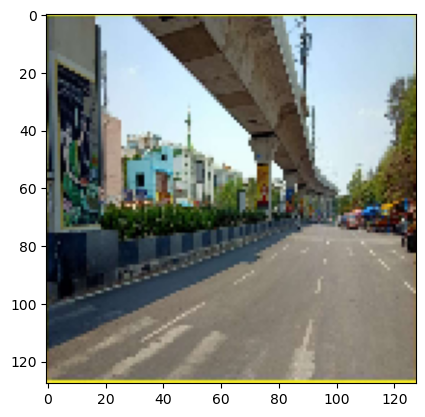

In [4]:
plt.imshow(images[1])

The first example image is this clean street above. We will plug this into the classifier to see what objects it detects.

In [5]:
#PROCESS IMAGE UTILITY
def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

In [6]:
#SHOW IMAGE UTILITY
def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

In [7]:
demoImage = preprocess_image(images[1])
classifier = hub.load(model_handle)

input_shape = demoImage.shape
warmup_input = tf.random.uniform(input_shape, 0, 1.0)
%time warmup_logits = classifier(warmup_input).numpy()

CPU times: user 492 ms, sys: 33.2 ms, total: 526 ms
Wall time: 703 ms


In [8]:
max_dynamic_size = 512
if model_name in model_image_size_map:
  image_size = model_image_size_map[model_name]
  dynamic_size = False
  print(f"Images will be converted to {image_size}x{image_size}")
else:
  dynamic_size = True
  print(f"Images will be capped to a max size of {max_dynamic_size}x{max_dynamic_size}")

labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []

with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels]

Images will be converted to 128x128
10484/10484 [==============================] - 0s 0us/step


CPU times: user 15.2 ms, sys: 3.18 ms, total: 18.4 ms
Wall time: 20.3 ms
(1)  840 - suspension bridge: 0.08165515959262848
(2)  707 - patio: 0.07770352065563202
(3)  836 - sundial: 0.04197488725185394
(4)  443 - bell cote: 0.04000387713313103
(5)  683 - obelisk: 0.033604275435209274


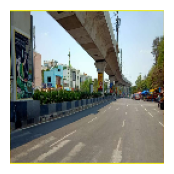

In [9]:
# Run model on image
%time probabilities = tf.nn.softmax(classifier(demoImage)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)

# Some models include an additional 'background' class in the predictions, so
# we must account for this when reading the class labels.
includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if includes_background_class else item + 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)

show_image(demoImage, '')

> Now lets see what happens when we feed it a more chaotic image, like one of the 'dirty' images that we have from our data.

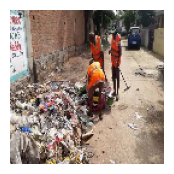

In [10]:
demoImage = preprocess_image(images[120])
show_image(demoImage, '')

CPU times: user 9.71 ms, sys: 2.94 ms, total: 12.6 ms
Wall time: 11.5 ms
(1)  666 - moped: 0.39420193433761597
(2)  492 - chain saw: 0.10857512056827545
(3)  831 - stretcher: 0.09726110845804214
(4)  671 - motor scooter: 0.051124028861522675
(5)  803 - snowmobile: 0.0255283210426569


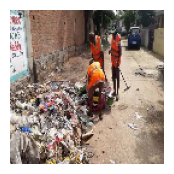

In [11]:
# Run model on image
%time probabilities = tf.nn.softmax(classifier(demoImage)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)

includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if includes_background_class else item + 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)

show_image(demoImage, '')

In [12]:
model_name = "mobilenetv2-035-128"

#NOTICE HOW WE ARE USING FEATURE VECTOR FOR THIS STEP AND NOT CLASSIFIER
model_handle_map = {
  "mobilenetv2-035-128": "/kaggle/input/mobilenet-v2/tensorflow2/035-128-feature-vector/2",
}

model_image_size_map = {
  "mobilenetv2-035-128": 128,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 128)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 4

Selected model: mobilenetv2-035-128 : /kaggle/input/mobilenet-v2/tensorflow2/035-128-feature-vector/2
Input size (128, 128)


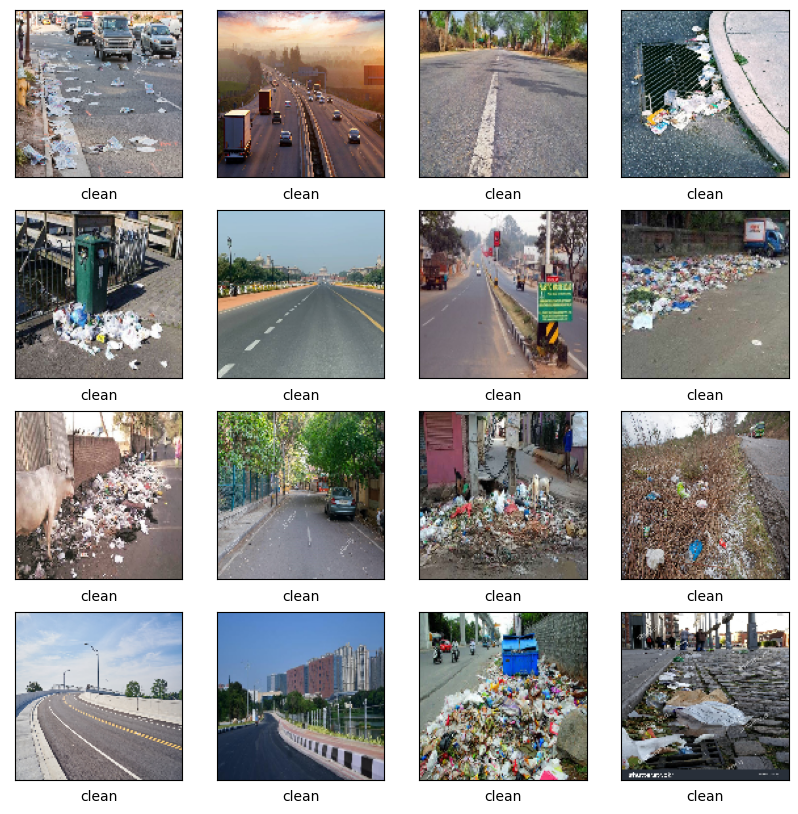

In [13]:
# Display 16 pictures from the dataset
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for x in range(4):
    for y in range(4):
        i = randint(0, len(images))
        
        axs[x][y].imshow(images[i])
        
        # delete x and y ticks and set x label as picture label
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])
        
plt.show()

In [14]:
images_path = '/kaggle/input/cleandirty-road-classification/Images/Images/'

labels_df = pd.read_csv('/kaggle/input/cleandirty-road-classification/metadata.csv')
print('\n\nlabels dataframe: \n', labels_df.head(), '\n\n')

class_names = ('clean', 'dirty')
num_classes = len(class_names)

img_size = (128, 128, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')


labels = []
images = []
for image in labels_df.iloc:
    images.append(np.asarray(cv2.resize(cv2.imread(images_path + image[0], cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1]))
    
    # labels will be in the form of a vector: [0, 1] or [1, 0]
    label = np.zeros(num_classes)
    label[image[1]] = 1
    labels.append(label)

labels = np.asarray(labels)
images = np.asarray(images)

print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')



labels dataframe: 
         filename  label
0    dirty_2.jpg      1
1   clean_36.jpg      0
2   clean_31.jpg      0
3   dirty_69.jpg      1
4  clean_113.jpg      0 


2 classes: ('clean', 'dirty')
image size: (128, 128, 3)

labels shape: (237, 2)
images shape: (237, 128, 128, 3)


In [15]:
# DEFINE TRAIN/TEST SPLIT
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (213, 128, 128, 3)
train labels shape: (213, 2)

validation images shape: (24, 128, 128, 3)
validation labels shape: (24, 2)



In [16]:
# ImageDataGenerator for train images
train_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.3,
                                                                         rotation_range=15,
                                                                         zoom_range=0.3,
                                                                         vertical_flip=True, 
                                                                         horizontal_flip=True)
train_images_generator = train_images_generator.flow(X_train, y=y_train)

# ImageDataGenerator for validation images
validation_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True, 
                                                                              horizontal_flip=True)
validation_images_generator = validation_images_generator.flow(X_val, y=y_val)

In [17]:
do_fine_tuning = False 

print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with /kaggle/input/mobilenet-v2/tensorflow2/035-128-feature-vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              410208    
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 412,770
Trainable params: 2,562
Non-trainable params: 410,208
_________________________________________________________________


In [18]:
# creating ModelChecpoint callback
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}')

## Compile and Train Model

In [19]:
model.compile(
  optimizer='adam', 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

train_size = X_train.shape[0]
valid_size = X_val.shape[0]
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_images_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_images_generator, callbacks=[checkpoint_callback])

Epoch 1/20
7/7 [==============================] - 14s 2s/step - loss: 0.8436 - accuracy: 0.4695 - val_loss: 0.7177 - val_accuracy: 0.5000
Epoch 2/20
7/7 [==============================] - 8s 1s/step - loss: 0.7069 - accuracy: 0.6244 - val_loss: 0.5555 - val_accuracy: 0.7500
Epoch 3/20
7/7 [==============================] - 8s 1s/step - loss: 0.6806 - accuracy: 0.6573 - val_loss: 0.5158 - val_accuracy: 0.8333
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 0.5919 - accuracy: 0.7230 - val_loss: 0.5281 - val_accuracy: 0.7500
Epoch 5/20
7/7 [==============================] - 8s 1s/step - loss: 0.6413 - accuracy: 0.6526 - val_loss: 0.5226 - val_accuracy: 0.6667
Epoch 6/20
7/7 [==============================] - 9s 1s/step - loss: 0.5723 - accuracy: 0.7324 - val_loss: 0.4965 - val_accuracy: 0.8333
Epoch 7/20
7/7 [==============================] - 8s 1s/step - loss: 0.5867 - accuracy: 0.7277 - val_loss: 0.4162 - val_accuracy: 0.8333
Epoch 8/20
7/7 [========================

> In just 10-20 epochs we already have about 90% accuracy

[](http://)

In [20]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(accuracy))

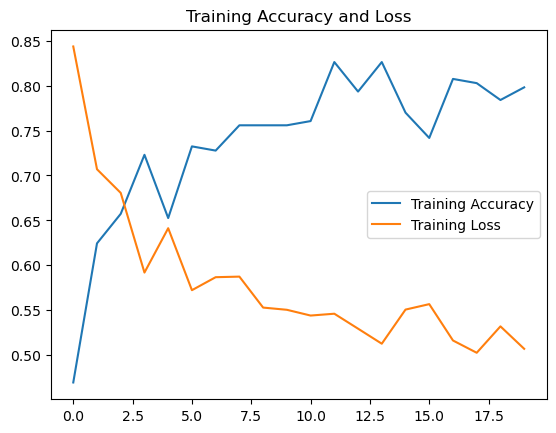

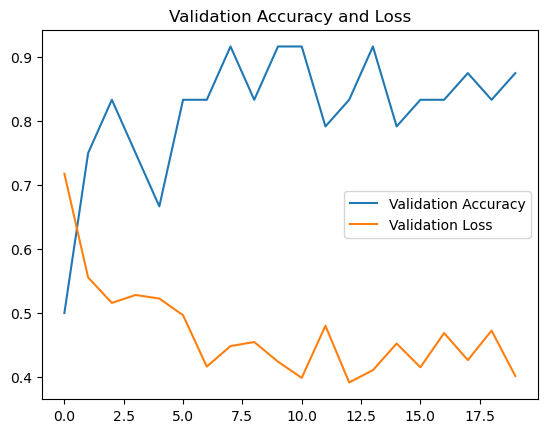

In [21]:
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()

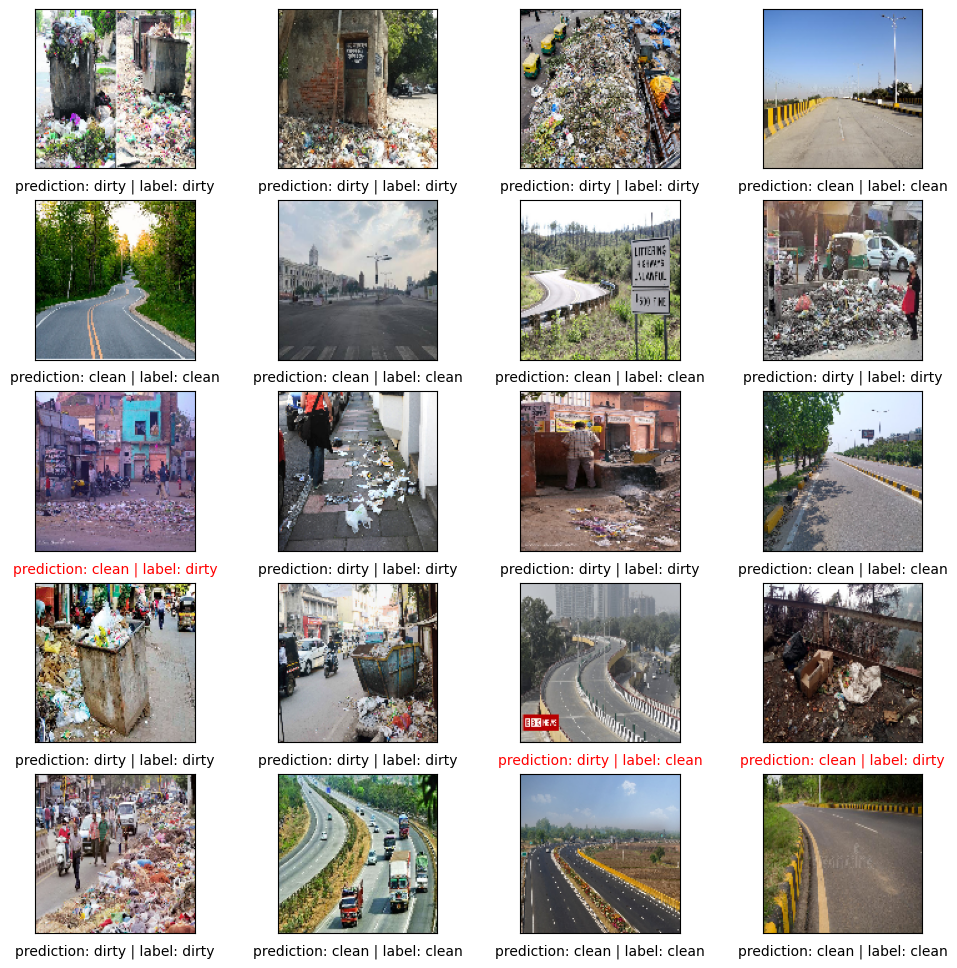

In [22]:
fig, axs = plt.subplots(5, 4, figsize=(12, 12))

i = 0
for x in range(5):
    for y in range(4):
        prediction = model.predict(X_val[i][None, ...], verbose=0)[0]
        
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        
        if np.argmax(prediction) != np.argmax(y_val[i]):   
            axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}', color='red')
        else:
            axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')
        
        axs[x][y].imshow(X_val[i])
        
        i += 1
plt.show()